In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:01<00:00, 43.5MB/s]
100% 2.29G/2.29G [01:01<00:00, 40.1MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest_xray_pneumonia')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data directories
data_dir = "./chest_xray_pneumonia/chest_xray/chest_xray"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

Using device: cuda


In [ ]:
# Define transformations
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # Randomly rotate by 10 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

In [ ]:
# Load data
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms["train"])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms["test"])

batch_size = 120  # Smaller batch size
data_loaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False),
}

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 5216
Testing dataset size: 624


In [ ]:
# Load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# Modify the final layer for binary classification
num_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout layer for regularization
    nn.Linear(num_features, 2)  # Output layer for two classes
)
resnet = resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-4)  # Added weight decay

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# Training loop with early stopping
num_epochs = 10
train_loss = []
val_loss = []
best_val_loss = float("inf")
patience = 5
counter = 0

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in data_loaders["train"]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    train_loss.append(running_loss / len(train_dataset))

    # Validation
    resnet.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loaders["test"]:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)

    val_loss.append(val_running_loss / len(test_dataset))
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}")

    # Early stopping
    if val_loss[-1] < best_val_loss:
        best_val_loss = val_loss[-1]
        counter = 0
        # Save the best model
        torch.save(resnet.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

    # Step the scheduler
    scheduler.step()


Epoch 1/10, Training Loss: 0.1693, Validation Loss: 0.2067
Epoch 2/10, Training Loss: 0.0656, Validation Loss: 0.3983
Epoch 3/10, Training Loss: 0.0559, Validation Loss: 0.2644
Epoch 4/10, Training Loss: 0.0461, Validation Loss: 0.4119
Epoch 5/10, Training Loss: 0.0328, Validation Loss: 0.4111
Epoch 6/10, Training Loss: 0.0319, Validation Loss: 0.3553
Early stopping


In [ ]:
# Evaluate the model
resnet.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in data_loaders["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.74      0.85       234
   PNEUMONIA       0.86      0.99      0.92       390

    accuracy                           0.90       624
   macro avg       0.93      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[173  61]
 [  2 388]]


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
sensitivity = recall  # Sensitivity is the same as recall
specificity = tn / (tn + fp)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

accuracy_percentage = accuracy * 100
precision_percentage = precision * 100
recall_percentage = recall * 100
specificity_percentage = specificity * 100
f1_percentage = f1 * 100

print(f"Accuracy: {accuracy_percentage:.2f}%")
print(f"Precision: {precision_percentage:.2f}%")
print(f"Recall (Sensitivity): {recall_percentage:.2f}%")
print(f"Specificity: {specificity_percentage:.2f}%")
print(f"F1 Score: {f1_percentage:.2f}%")

Confusion Matrix:
[[173  61]
 [  2 388]]
Accuracy: 89.90%
Precision: 86.41%
Recall (Sensitivity): 99.49%
Specificity: 73.93%
F1 Score: 92.49%


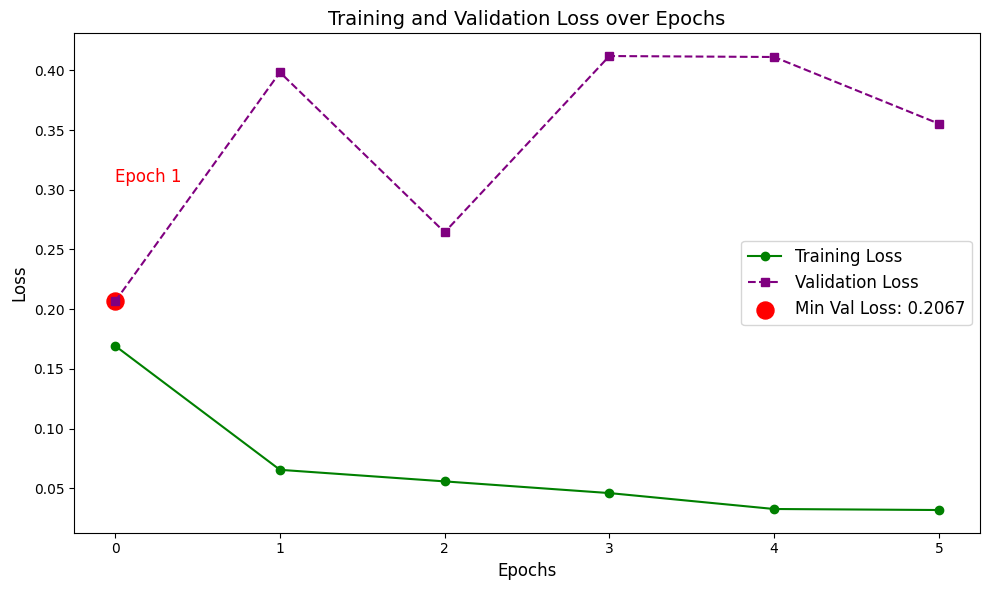

In [ ]:
import matplotlib.pyplot as plt

# Interactive and colorful plot for Training and Validation Loss
plt.figure(figsize=(10, 6))

# Plot training loss with distinct color
plt.plot(range(len(train_loss)), train_loss, label="Training Loss", linestyle='-', marker='o', color='green')

# Plot validation loss with distinct color
plt.plot(range(len(val_loss)), val_loss, label="Validation Loss", linestyle='--', marker='s', color='purple')

# Add labels and title
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss over Epochs", fontsize=14)

# Highlighting minimum validation loss with a big marker
min_val_loss = min(val_loss)
min_val_loss_epoch = val_loss.index(min_val_loss)
plt.scatter(min_val_loss_epoch, min_val_loss, color='red', s=150, label=f"Min Val Loss: {min_val_loss:.4f}")  # Larger marker
plt.text(min_val_loss_epoch, min_val_loss + 0.1, f"Epoch {min_val_loss_epoch + 1}", color='red', fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()
